In [ ]:
#pip install pennylane


In [ ]:
#pip install pennylane-qiskit

In [ ]:
#pip install --upgrade pennylane numpy scikit-learn

SVM Accuracy: 1.0


C:\Users\Laverne\anaconda3\lib\site-packages\pennylane\_grad.py:112: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


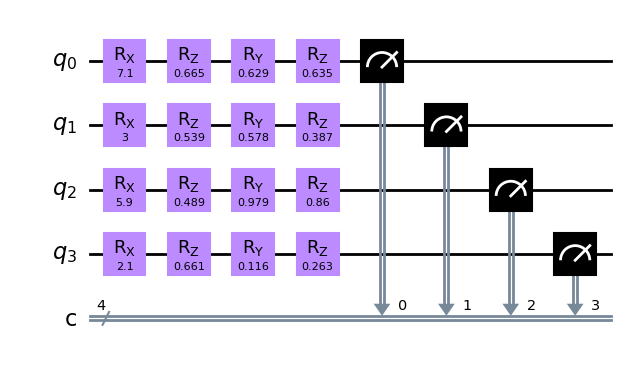

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pennylane as qml

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

# QSVM
n_qubits = 4  # Number of qubits matches the number of features
dev = qml.device("qiskit.aer", wires=n_qubits)

@qml.qnode(dev)
def qsvm_circuit(x, weights):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.Rot(*weights[0], wires=0)
    qml.Rot(*weights[1], wires=1)
    qml.Rot(*weights[2], wires=2)
    qml.Rot(*weights[3], wires=3)
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))]

def qsvm_cost(weights):
    predictions = np.asarray([qsvm_circuit(x, weights) for x in X_train])
    dot_product = np.dot(predictions.T, y_train) / len(X_train)
    return np.sum(np.sin(1 - dot_product))

# Randomly initialize weights
weights = np.random.uniform(size=(4, 3))

opt = qml.GradientDescentOptimizer(stepsize=0.1)

for it in range(3):
    weights = opt.step(qsvm_cost, weights)

# Test the models on the same testing set
qsvm_pred = np.argmax([qsvm_circuit(x, weights) for x in X_test], axis=1)

# Calculate evaluation metrics for both models
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred, average='macro')
svm_recall = recall_score(y_test, svm_pred, average='macro')
svm_f1 = f1_score(y_test, svm_pred, average='macro')

qsvm_accuracy = accuracy_score(y_test, qsvm_pred)
qsvm_precision = precision_score(y_test, qsvm_pred, average='macro')
qsvm_recall = recall_score(y_test, qsvm_pred, average='macro')
qsvm_f1 = f1_score(y_test, qsvm_pred, average='macro')

# Print the metrics for both models
print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1 Score:", svm_f1)

print("QSVM Accuracy:", qsvm_accuracy)
print("QSVM Precision:", qsvm_precision)
print("QSVM Recall:", qsvm_recall)
print("QSVM F1 Score:", qsvm_f1)

dev._circuit.draw(output="mpl")
